# Laboratory 9: Fast Fourier Transforms

## Objectives

In this lab, you will explore Fast Fourier Transforms as a method of analysing and filtering data. The goal is to gain a better understanding of how Fourier transforms can be used to analyse the power spectral density of data (how much power there is in different frequencies) and for filtering data (removing certain frequencies from the data, whether that's trying to remove noise, or isolating some frequencies of interest).

Specifically you will be able to:

-   understand how sampling frequency can impact the frequencies you can detect in data

-   use Fourier transforms to analyse atmospheric wind measurements and calculate and plot power spectral densities

-   use Fourier transforms to filter data by removing particular frequencies

## Introduction 

This lab introduces the use of the fast Fourier transform for estimation
of the power spectral density and for simple filtering.  If you need a refresher or
are learning about fourier transforms for the first time,  we recommend reading
[Newman Chapter 7](https://owncloud.eoas.ubc.ca/s/STrxS2pXewjqdYt).  For a description of the Fast Fourier transform,
see [Stull Section 8.4](https://owncloud.eoas.ubc.ca/s/KMfPeGPLs2Fe7Qq) and [Jake VanderPlas's blog entry](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/).  Another good resources is
[Numerical Recipes Chapter 12](https://nextcloud.eoas.ubc.ca/s/cnbBeQ47qBMgq3K)

Before running this lab you will need to:  
    1. Install netCDF4 by running:
    
    conda install netCDF4 
    
after you have activated your numeric_2024 conda environment  
    
2. download some data by running the cell below



In [2]:
# Download some data that we will need:
from matplotlib import pyplot as plt
import urllib
import os
filelist=['miami_tower.npz','a17.nc','aircraft.npz']
data_download=True
if data_download:
    for the_file in filelist:
        url='http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}'.format(the_file)
        urllib.request.urlretrieve(url,the_file)
        print("download {}: size is {:6.2g} Mbytes".format(the_file,os.path.getsize(the_file)*1.e-6))

download miami_tower.npz: size is    1.5 Mbytes
download a17.nc: size is     17 Mbytes
download aircraft.npz: size is   0.73 Mbytes


In [3]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## A simple transform

To get started assume that there is a pure tone -- a cosine wave oscillating at a frequency of 1 Hz.  Next assume that we sample that 1 Hz wave at a sampling rate of 5 Hz i.e. 5 times a second



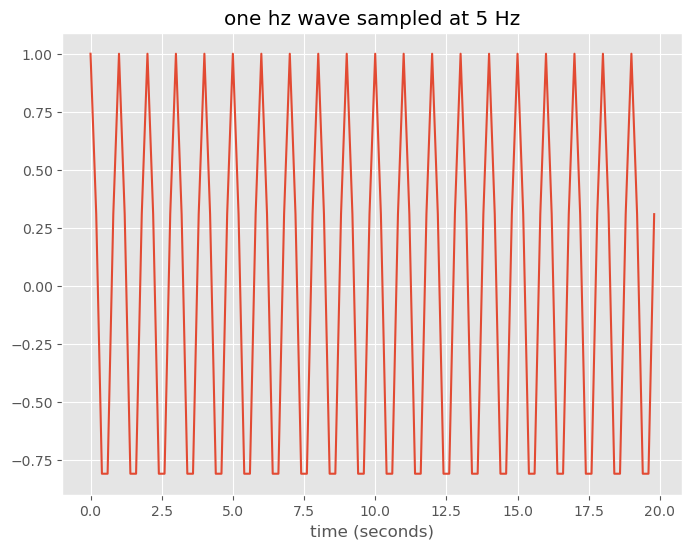

In [4]:
%matplotlib inline
#
# create a cosine wave that oscilates 20 times in 20 seconds
# sampled at 5 Hz, so there are 20*5 = 100 measurements in 20 seconds
#
deltaT=0.2
ticks = np.arange(0,20,deltaT)
#
#20 cycles in 20 seconds, each cycle goes through 2*pi radians
#
onehz=np.cos(2.*np.pi*ticks)
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(ticks,onehz)
ax.set_title('one hz wave sampled at 5 Hz')
out=ax.set_xlabel('time (seconds)')

Repeat, but for a 2 Hz wave

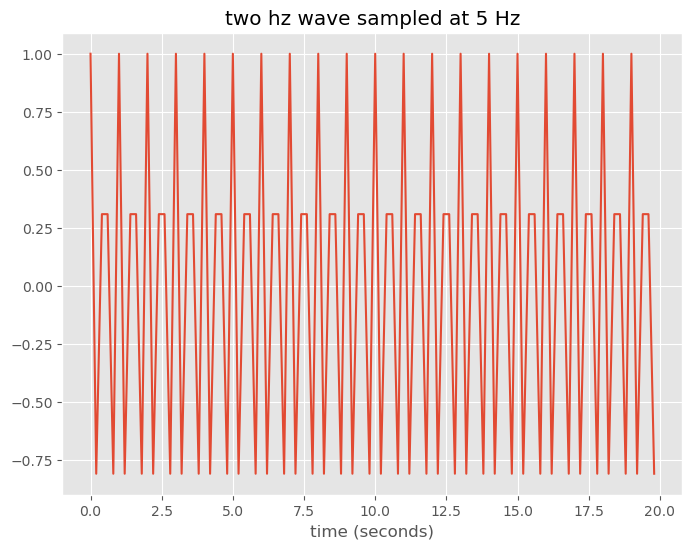

In [5]:
deltaT=0.2
ticks = np.arange(0,20,deltaT)
#
#40 cycles in 20 seconds, each cycle goes through 2*pi radians
#
twohz=np.cos(2.*2.*np.pi*ticks)
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(ticks,twohz)
ax.set_title('two hz wave sampled at 5 Hz')
out=ax.set_xlabel('time (seconds)')

Note the problem at 2 Hz,  the 5 Hz sampling frequency is too coarse to hit the top of every other
peak in the wave. The 'Nyquist frequency' = 2 $\times$ the sampling rate, is the highest frequency that equipment of a given sampling rate can reliably measure. In this example where we are measuring 5 times a second (i.e. at 5Hz), the Nyquist frequency is 2.5Hz. Note that, whilst the 2Hz signal is below the Nyquist frequency, and so it is measurable and we do detect a 2Hz signal, because 2Hz is close to the Nyquist frequency of 2.5Hz, the signal is being distorted.

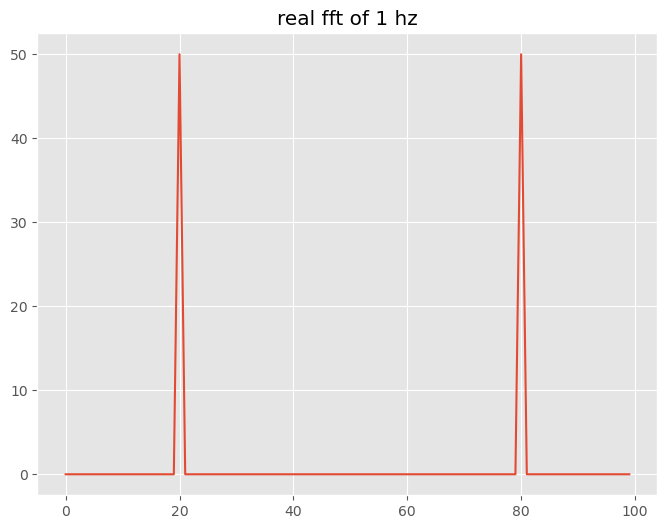

In [6]:
#now take the fft, we have 100 bins, so we alias at 50 bins, which is the nyquist frequency of 5 Hz/2. = 2.5 Hz
# so the fft frequency resolution is 20 bins/Hz, or 1 bin = 0.05 Hz
thefft=np.fft.fft(onehz)
real_coeffs=np.real(thefft)

fig,theAx=plt.subplots(1,1,figsize=(8,6))
theAx.plot(real_coeffs)
out=theAx.set_title('real fft of 1 hz')

The layout of the fft return value is describe in 
[the scipy user manual](http://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html#id9).   
For reference, here is the Fourier transform calculated by numpy.fft:

$$y[k] = \sum_{n=0}^{N-1} x[n]\exp \left (- i 2 \pi k n /N \right )$$

which is the discrete version of the continuous transform (Numerical Recipes 12.0.4):

$$y(k) = \int_{-\infty}^{\infty} x(t) \exp \left ( -i k t \right ) dt$$

(Note the different minus sign convention in the exponent compared to Numerical Recipes p. 490.  It doesn't matter what you choose, as long as you're consistent).

From the Scipy manual:

> Inserting k=0 we see that np.sum(x)  corresponds to y[0]. This term will be non-zero if we haven't removed any large scale trend in the data. For N even, the elements y[1]...y[N/2−1] contain the positive-frequency terms, and the elements y[N/2]...y[N−1] contain the negative-frequency terms, in order of decreasingly negative frequency. For N odd, the elements y[1]...y[(N−1)/2] contain the positive- frequency terms, and the elements y[(N+1)/2]...y[N−1] contain the negative- frequency terms, in order of decreasingly negative frequency.
> In case the sequence x is real-valued, the values of y[n] for positive frequencies is the conjugate of the values y[n] for negative frequencies (because the spectrum is symmetric). Typically, only the FFT corresponding to positive frequencies is plotted.

So the first peak at index 20 is (20 bins) x (0.05 Hz/bin) = 1 Hz, as expected.  The nyquist frequency of 2.5 Hz is at an index of N/2 = 50 and the negative frequency peak is 20 bins to the left of the end bin.


The inverse transform is:

$$x[n] = \frac{1}{N} \sum_{k=0}^{N-1} y]k]\exp \left ( i 2 \pi k n /N \right )$$

What about the imaginary part?  All imaginary coefficients are zero (neglecting roundoff errors)

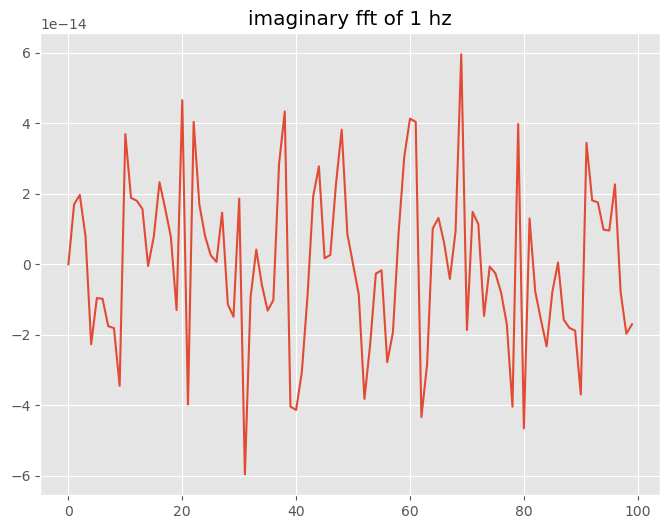

In [7]:
imag_coeffs=np.imag(thefft)
fig,theAx=plt.subplots(1,1,figsize=(8,6))
theAx.plot(imag_coeffs)
out=theAx.set_title('imaginary fft of 1 hz')

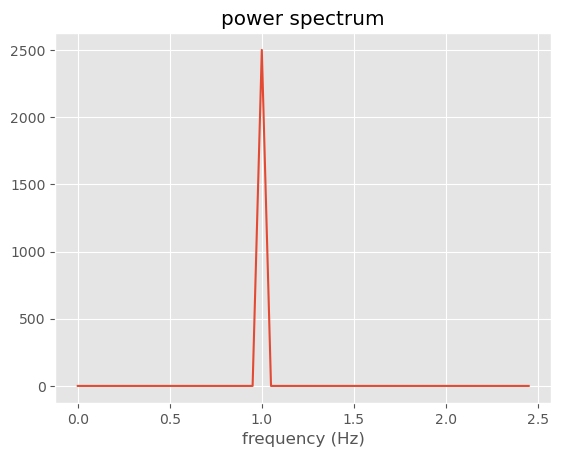

In [8]:
#now evaluate the power spectrum using Stull's 8.6.1a on p. 312

Power=np.real(thefft*np.conj(thefft))
totsize=len(thefft)
halfpoint=int(np.floor(totsize/2.))
firsthalf=Power[0:halfpoint]


fig,ax=plt.subplots(1,1)
freq=np.arange(0,5.,0.05)
ax.plot(freq[0:halfpoint],firsthalf)
ax.set_title('power spectrum')
out=ax.set_xlabel('frequency (Hz)')
len(freq)
plt.show()

Check Stull 8.6.1b (or Numerical Recipes 12.0.13) which says that squared power spectrum = variance


In [8]:
print('\nsimple cosine: velocity variance %10.3f' % (np.sum(onehz*onehz)/totsize))
print('simple cosine: Power spectrum sum %10.3f\n' % (np.sum(Power)/totsize**2.))


simple cosine: velocity variance      0.500
simple cosine: Power spectrum sum      0.500



## Power spectrum of turbulent vertical velocity

Let's apply fft to some real atmospheric measurements. We'll read in one of the files we downloaded at the beginning of the lab (you should be able to see these files on your local computer in this Lab9 directory).

In [9]:
#load data sampled at 20.8333 Hz

td=np.load('miami_tower.npz') #load temp, uvel, vvel, wvel, minutes
print('keys: ',td.keys())
# Print the description saved in the file so we know what data are in the file
print(td['description'])

keys:  KeysView(NpzFile 'miami_tower.npz' with keys: wvel, vvel, minutes, temp, __header__...)

These are measurements of atmospheric
turbulent velocity (wvel, uvel, vvel (m/s) and temperature (temp), taken
over a 30 minute period at a sampling rate of 20.8333 (125/6)
Hz. They were measured by a sonic anemometer at a height of 40 m over
suburban Miami during unstable conditions (12:01-12:31 LAT)

Total length of each timeseries is 37,500 values, so total sample time is
37000*(6/125) = 1800 seconds = 30 minutes



check Wiener-Khichine theorem for wvel

raw fft sum, full time series:     1.0337

velocity variance:     1.0337



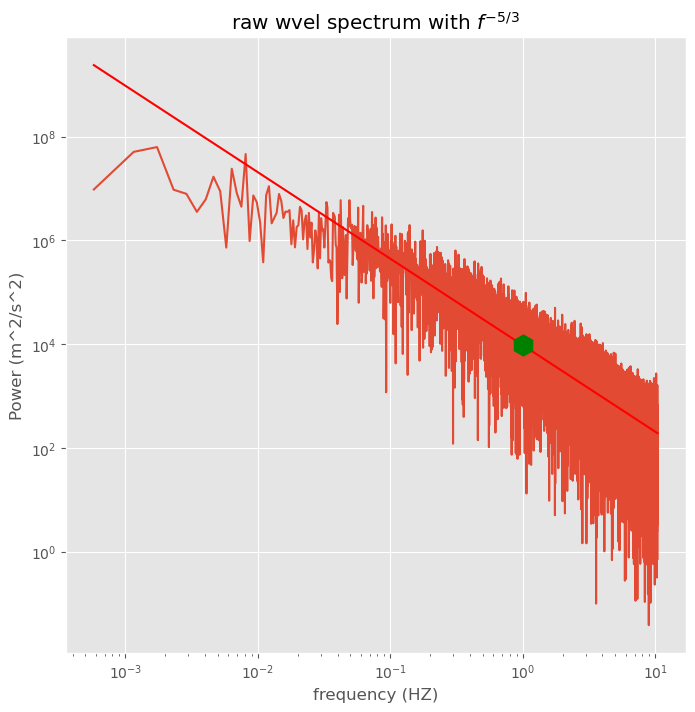

In [10]:
# calculate the fft and plot the frequency-power spectrum
sampleRate=20.833
nyquistfreq=sampleRate/2.


totsize=36000
wvel=td['wvel'][0:totsize].flatten()
temp=td['temp'][0:totsize].flatten()
wvel = wvel - np.mean(wvel)
temp= temp - np.mean(temp)
flux=wvel*temp


halfpoint=int(np.floor(totsize/2.))
frequencies=np.arange(0,halfpoint)
frequencies=frequencies/halfpoint
frequencies=frequencies*nyquistfreq

# raw spectrum -- no windowing or averaging
#First confirm Parseval's theorem
# (Numerical Recipes 12.1.10, p. 498)

thefft=np.fft.fft(wvel)
Power=np.real(thefft*np.conj(thefft))
print('check Wiener-Khichine theorem for wvel')
print('\nraw fft sum, full time series: %10.4f\n' % (np.sum(Power)/totsize**2.))
print('velocity variance: %10.4f\n' % (np.sum(wvel*wvel)/totsize))


fig,theAx=plt.subplots(1,1,figsize=(8,8))
frequencies[0]=np.NaN
Power[0]=np.NaN
Power_half=Power[:halfpoint:]
theAx.loglog(frequencies,Power_half)
theAx.set_title('raw wvel spectrum with $f^{-5/3}$')
theAx.set(xlabel='frequency (HZ)',ylabel='Power (m^2/s^2)')
#
# pick one point the line should pass through (by eye)
# note that y intercept will be at log10(freq)=0
# or freq=1 Hz
#
leftspec=np.log10(Power[1]*1.e-3)
logy=leftspec - 5./3.*np.log10(frequencies)
yvals=10.**logy
theAx.loglog(frequencies,yvals,'r-')
thePoint=theAx.plot(1.,Power[1]*1.e-3,'g+')
thePoint[0].set_markersize(15)
thePoint[0].set_marker('h')
thePoint[0].set_markerfacecolor('g')

## power spectrum layout

Here is what the entire power spectrum looks like, showing positive and negative frequencies

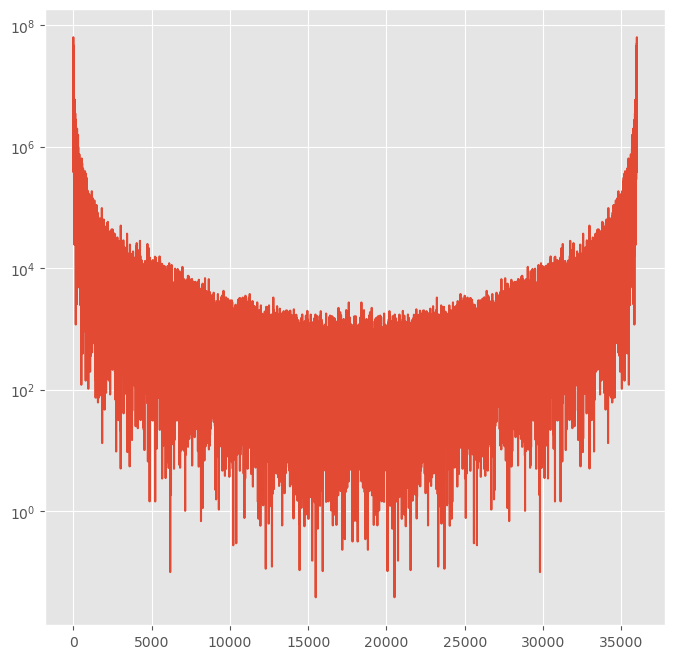

In [11]:
fig,theAx=plt.subplots(1,1,figsize=(8,8))
out=theAx.semilogy(Power)

and here is what fftshift does:

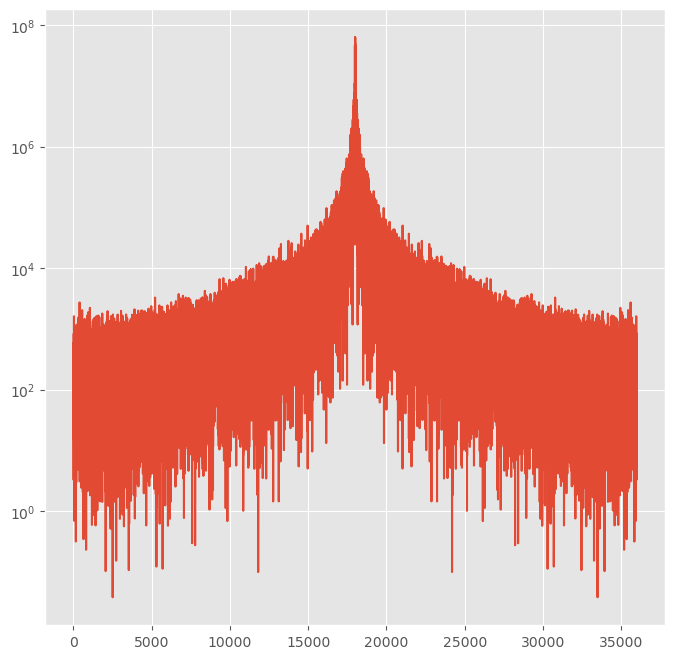

In [12]:
shift_power=np.fft.fftshift(Power)
fig,theAx=plt.subplots(1,1,figsize=(8,8))
out=theAx.semilogy(shift_power)

### Confirm that the fft at negative f is the complex conjugate of the fft at positive f

(200.4277107839311-150.32508399544918j)
(200.42771078393093+150.32508399544923j)


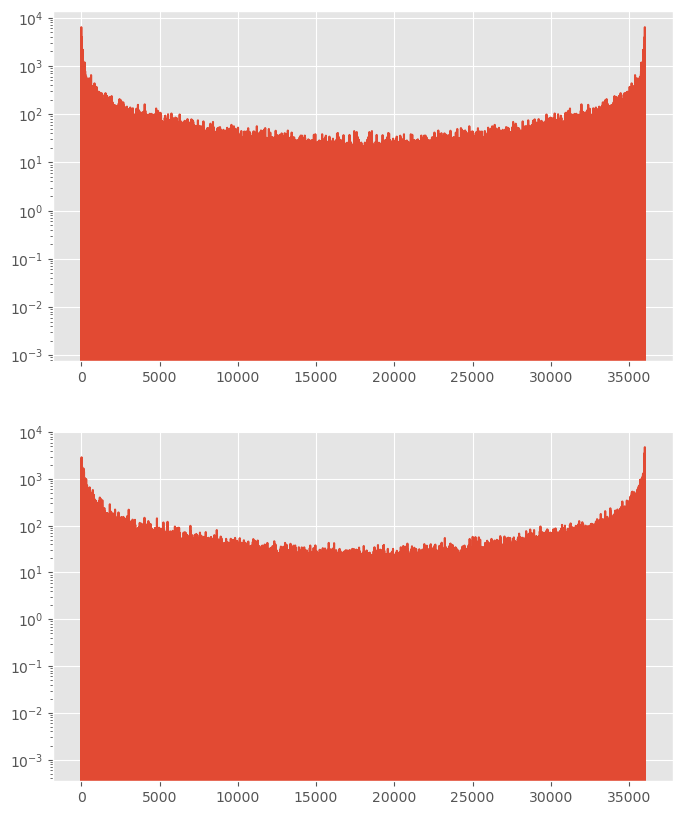

In [13]:
test_fft=np.fft.fft(wvel)
fig,theAx=plt.subplots(2,1,figsize=(8,10))
theAx[0].semilogy(np.real(test_fft))
theAx[1].semilogy(np.imag(test_fft))
print(test_fft[100])
print(test_fft[-100])

## Windowing

The FFT above is noisy, and there are several ways to smooth it.  Numerical Recipes, p. 550 has a good discussion of "windowing" which helps remove the spurious power caused by the fact that the timeseries has a sudden stop and start.
Below we split the timeseries into 25 segements of 1440 points each, fft each segment then average the 25.  We convolve each segment with a Bartlett window.




Try a windowed spectrum (Bartlett window)

sumw:      0.533


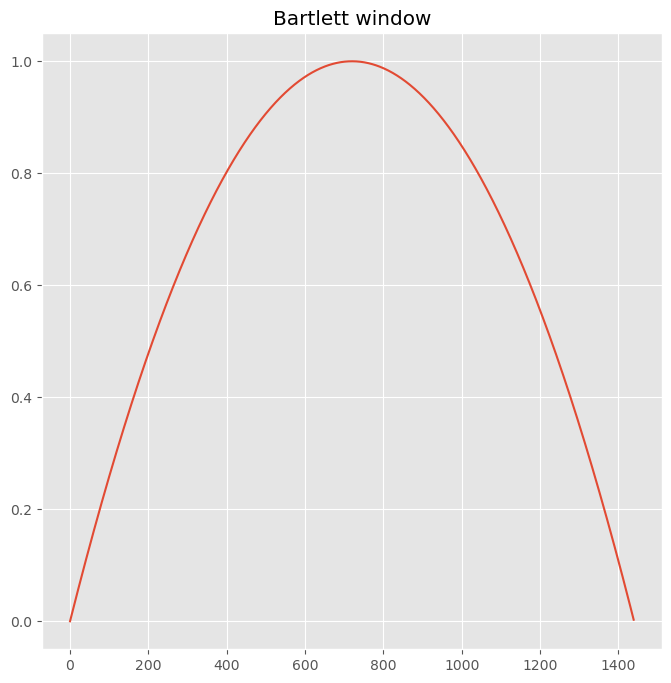

In [14]:
print('\n\n\nTry a windowed spectrum (Bartlett window)\n')
## windowing -- see p. Numerical recipes 550 for notation

def calc_window(numvals=1440):
    """
      Calculate a Bartlett window following
      Numerical Recipes 13.4.13
    """

    halfpoint=int(np.floor(numvals/2.))
    facm=halfpoint
    facp=1/facm

    window=np.empty([numvals],float)
    for j in np.arange(numvals):
        window[j]=(1.-((j - facm)*facp)**2.)
    return window

#
#  we need to normalize by the squared weights
#  (see the fortran code on Numerical recipes p. 550)
#
numvals=1440
window=calc_window(numvals=numvals)
sumw=np.sum(window**2.)/numvals
fig,theAx=plt.subplots(1,1,figsize=(8,8))
theAx.plot(window)
theAx.set_title('Bartlett window')
print('sumw: %10.3f' % sumw)

In [15]:
def do_fft(the_series,window,ensemble=25,title='title'):
    numvals=len(window)
    sumw=np.sum(window**2.)/numvals
    subset=the_series.copy()
    subset=subset[:len(window)*ensemble]
    subset=np.reshape(subset,(ensemble,numvals))
    winspec=np.zeros([numvals],float)

    for therow in np.arange(ensemble):
        thedat=subset[therow,:]
        thefft =np.fft.fft(thedat*window)
        Power=thefft*np.conj(thefft)
        #print('\nensemble member: %d' % therow)
        #print('\nwindowed fft sum (m^2/s^2): %10.4f\n' % (np.sum(Power)/(sumw*numvals**2.),))
        #print('velocity variance (m^2/s^2): %10.4f\n\n' % (np.sum(thedat*thedat)/numvals,))
        winspec=winspec + Power

    winspec=np.real(winspec/(numvals**2.*ensemble*sumw))
    return winspec

## Compare power spectra for wvel, theta, sensible heat flux

### start with wvel

In [16]:
winspec=do_fft(wvel,window)
sampleRate=20.833
nyquistfreq=sampleRate/2.
halfpoint=int(len(winspec)/2.)
averaged_freq=np.linspace(0,1.,halfpoint)*nyquistfreq
winspec=winspec[0:halfpoint]

<>:18: SyntaxWarning: invalid escape sequence '\,'
<>:18: SyntaxWarning: invalid escape sequence '\,'
/var/folders/3m/_312y20d73x4r2_rgb9fmw1r0000gp/T/ipykernel_20135/3650097792.py:18: SyntaxWarning: invalid escape sequence '\,'
  labels=dict(title='wvel power spectrum',ylabel='$(m^2\,s^{-2}\,Hz^{-1})$')


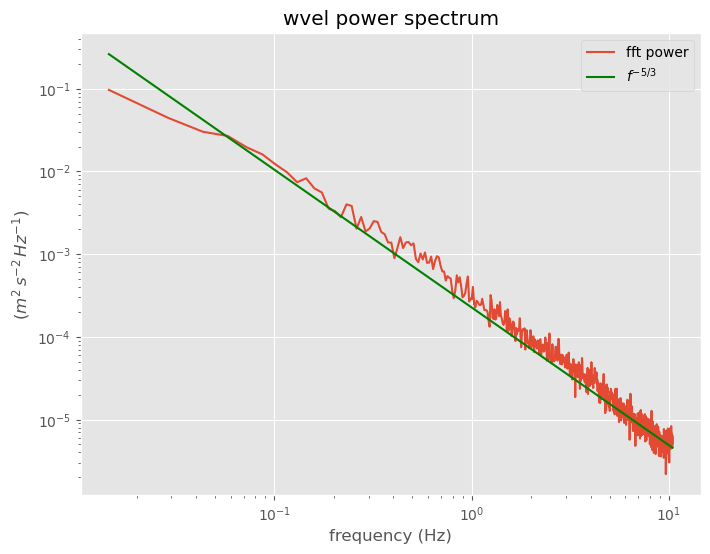

In [17]:
def do_plot(the_freq,the_spec,title=None,ylabel=None):
    the_freq[0]=np.NaN
    the_spec[0]=np.NaN
    fig,theAx=plt.subplots(1,1,figsize=(8,6))
    theAx.loglog(the_freq,the_spec,label='fft power')
    if title:
        theAx.set_title(title)
    leftspec=np.log10(the_spec[int(np.floor(halfpoint/10.))])
    logy=leftspec - 5./3.*np.log10(the_freq)
    yvals=10.**logy
    theAx.loglog(the_freq,yvals,'g-',label='$f^{-5/3}$')
    theAx.set_xlabel('frequency (Hz)')
    if ylabel:
        out=theAx.set_ylabel(ylabel)
    out=theAx.legend(loc='best')
    return theAx

labels=dict(title='wvel power spectrum',ylabel='$(m^2\,s^{-2}\,Hz^{-1})$')
ax=do_plot(averaged_freq,winspec,**labels)

<>:3: SyntaxWarning: invalid escape sequence '\,'
<>:3: SyntaxWarning: invalid escape sequence '\,'
/var/folders/3m/_312y20d73x4r2_rgb9fmw1r0000gp/T/ipykernel_20135/1169166308.py:3: SyntaxWarning: invalid escape sequence '\,'
  labels=dict(title='Temperature power spectrum',ylabel='$K^{2}\,Hz^{-1})$')


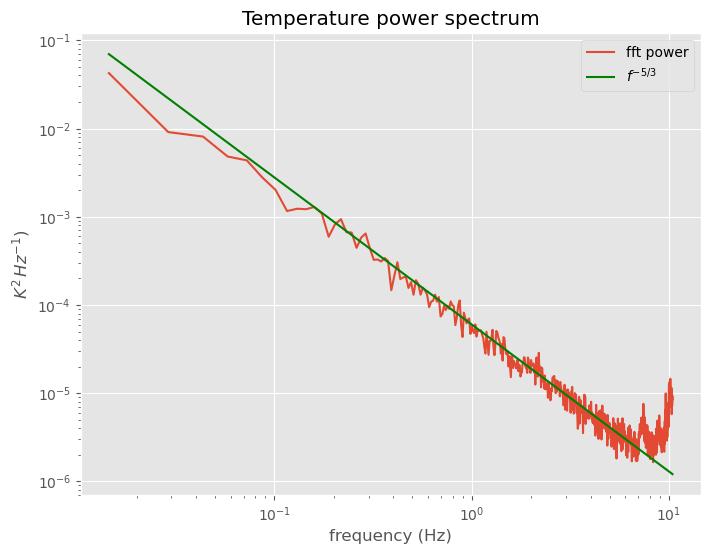

In [18]:
winspec=do_fft(temp,window)
winspec=winspec[0:halfpoint]
labels=dict(title='Temperature power spectrum',ylabel='$K^{2}\,Hz^{-1})$')
ax=do_plot(averaged_freq,winspec,**labels)

<>:3: SyntaxWarning: invalid escape sequence '\,'
<>:3: SyntaxWarning: invalid escape sequence '\,'
/var/folders/3m/_312y20d73x4r2_rgb9fmw1r0000gp/T/ipykernel_20135/3333423018.py:3: SyntaxWarning: invalid escape sequence '\,'
  labels=dict(title='Heat flux power spectrum',ylabel='$K m s^{-1}\,Hz^{-1})$')


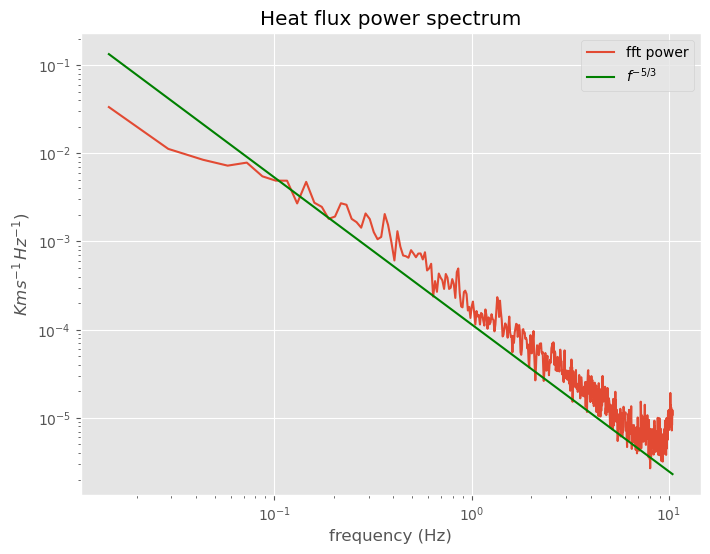

In [19]:
winspec=do_fft(flux,window)
winspec=winspec[0:halfpoint]
labels=dict(title='Heat flux power spectrum',ylabel='$K m s^{-1}\,Hz^{-1})$')
ax=do_plot(averaged_freq,winspec,**labels)

## Filtering

We can also filter our timeseries by removing frequencies we aren't interested in. Numerical Recipes discusses the approach on page 551.  For example, suppose we want to filter all frequencies higher than 0.5 Hz from the vertical velocity data.

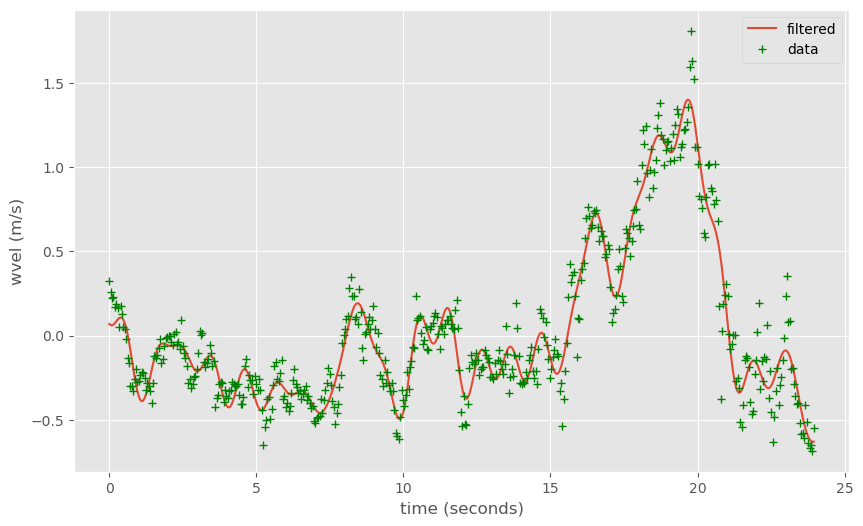

In [20]:
wvel= wvel - np.mean(wvel)
thefft=np.fft.fft(wvel)
totsize=len(thefft)
samprate=20.8333 #Hz
the_time=np.arange(0,totsize,1/20.8333)
freq_bin_width=samprate/(totsize*2)
half_hz_index=int(np.floor(0.5/freq_bin_width))
filter_func=np.zeros_like(thefft,dtype=np.float64)
filter_func[0:half_hz_index]=1.
filter_func[-half_hz_index:]=1.
filtered_wvel=np.real(np.fft.ifft(filter_func*thefft))
fig,ax=plt.subplots(1,1,figsize=(10,6))
numpoints=500
ax.plot(the_time[:numpoints],filtered_wvel[:numpoints],label='filtered')
ax.plot(the_time[:numpoints],wvel[:numpoints],'g+',label='data')
ax.set(xlabel='time (seconds)',ylabel='wvel (m/s)')
out=ax.legend()

In [35]:
half_hz_index

1728

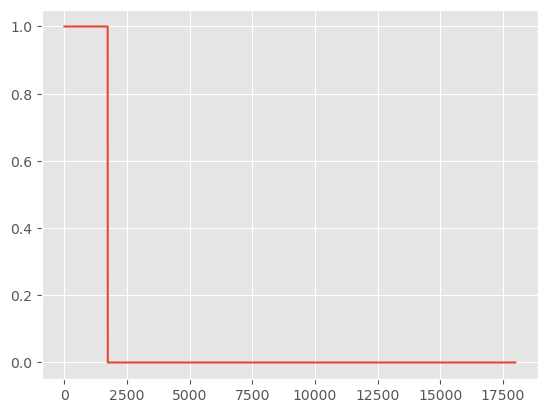

In [33]:
plt.plot(filter_func[:int(len(filter_func)/2)])

## 2D histogram of the optical depth $\tau$


Below I calculate the 2-d and averaged 1-d spectra for the optical depth, which gives the penetration depth of photons through a cloud, and is closely related to cloud thickness

In [21]:
# this allows us to ignore (not print out) some warnings
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [22]:
import netCDF4
from netCDF4 import Dataset
filelist=['a17.nc']
with Dataset(filelist[0]) as nc:
    tau=nc.variables['tau'][...]

## Character of the optical depth field

The image below shows one of the marine boundary layer landsat scenes analyzed in 
[Lewis et al., 2004](http://onlinelibrary.wiley.com/doi/10.1029/2003JD003742/full)

It is a 2048 x 2048 pixel image taken by Landsat 7, with the visible reflectivity converted to
cloud optical depth.   The pixels are 25 m x 25 m, so the scene extends for about 50 km x 50 km

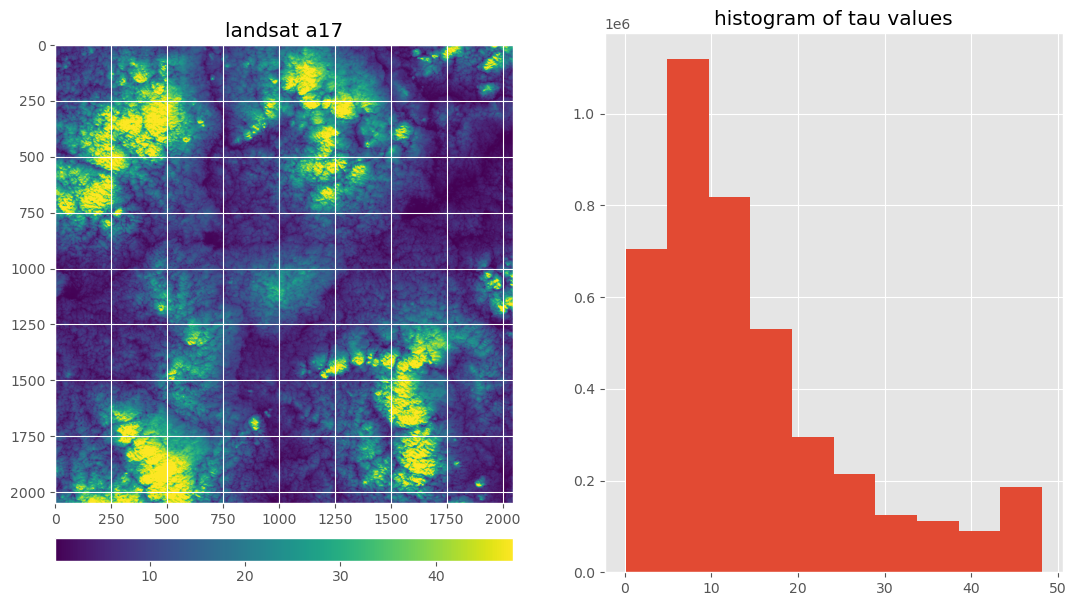

In [23]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.close('all')
fig,ax=plt.subplots(1,2,figsize=(13,7))
ax[0].set_title('landsat a17')
im0=ax[0].imshow(tau)
im1=ax[1].hist(tau.ravel())
ax[1].set_title('histogram of tau values')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im0,orientation='horizontal',cax=cax)

## ubc_fft class

In the next cell I define a class that calculates the 2-d fft for a square image

in the method ```power_spectrum``` we calculate both the 2d fft and the power spectrum
and save them as class attributes.  In the method ```annular_average``` I take the power spectrum,
which is the two-dimensional field  $E(k_x, k_y)$ (in cartesian coordinates) or $E(k,\theta)$ (in polar coordinates).
In the method ```annular_avg``` I take the average

$$
\overline{E}(k) = \int_0^{2\pi} E(k, \theta) d\theta
$$

and plot that average with the method ```graph_spectrum```

In [24]:
from netCDF4 import Dataset
import numpy as np
import math
from numpy import fft
from matplotlib import pyplot as plt


class ubc_fft:

    def __init__(self, filename, var, scale):
        """
           Input filename, var=variable name,
           scale= the size of the pixel in km

           Constructer opens the netcdf file, reads the data and
           saves the twodimensional fft
        """
        with Dataset(filename,'r') as fin:
            data = fin.variables[var][...]
        data = data - data.mean()
        if data.shape[0] != data.shape[1]:
            raise ValueError('expecting square matrix')
        self.xdim = data.shape[0]     # size of each row of the array
        self.midpoint = int(math.floor(self.xdim/2))
        root,suffix = filename.split('.')
        self.filename = root
        self.var = var
        self.scale = float(scale)
        self.data = data
        self.fft_data = fft.fft2(self.data)

    def power_spectrum(self):
        """
           calculate the power spectrum for the 2-dimensional field
        """
        #
        # fft_shift moves the zero frequency point to the  middle
        # of the array
        #
        fft_shift = fft.fftshift(self.fft_data)
        spectral_dens = fft_shift*np.conjugate(fft_shift)/(self.xdim*self.xdim)
        spectral_dens = spectral_dens.real
        #
        # dimensional wavenumbers for 2dim spectrum  (need only the kx
        # dimensional since image is square
        #
        k_vals = np.arange(0,(self.midpoint))+1
        k_vals = (k_vals-self.midpoint)/(self.xdim*self.scale)
        self.spectral_dens=spectral_dens
        self.k_vals=k_vals

    def annular_avg(self,avg_binwidth):
        """
         integrate the 2-d power spectrum around a series of rings
         of radius kradial and average into a set of 1-dimensional
         radial bins
        """
        #
        #  define the k axis which is the radius in the 2-d polar version of E
        #
        numbins = int(round((math.sqrt(2)*self.xdim/avg_binwidth),0)+1)

        avg_spec = np.zeros(numbins,np.float64)
        bin_count = np.zeros(numbins,np.float64)

        print("\t- INTEGRATING... ")
        for i in range(self.xdim):
            if (i%100) == 0:
                print("\t\trow: {} completed".format(i))
            for j in range(self.xdim):
                kradial = math.sqrt(((i+1)-self.xdim/2)**2+((j+1)-self.xdim/2)**2)
                bin_num = int(math.floor(kradial/avg_binwidth))
                avg_spec[bin_num]=avg_spec[bin_num]+ kradial*self.spectral_dens[i,j]
                bin_count[bin_num]+=1

        for i in range(numbins):
            if bin_count[i]>0:
                avg_spec[i]=avg_spec[i]*avg_binwidth/bin_count[i]/(4*(math.pi**2))
        self.avg_spec=avg_spec
        #
        # dimensional wavenumbers for 1-d average spectrum
        #
        self.k_bins=np.arange(numbins)+1
        self.k_bins = self.k_bins[0:self.midpoint]
        self.avg_spec = self.avg_spec[0:self.midpoint]



    def graph_spectrum(self, kol_slope=-5./3., kol_offset=1., \
                      title=None):
        """
           graph the annular average and compare it to Kolmogorov -5/3
        """
        avg_spec=self.avg_spec
        delta_k = 1./self.scale                # 1./km (1/0.025 for landsat 25 meter pixels)
        nyquist = delta_k * 0.5
        knum = self.k_bins * (nyquist/float(len(self.k_bins)))# k = w/(25m)
        #
        # draw the -5/3 line through a give spot
        #
        kol = kol_offset*(knum**kol_slope)
        fig,ax=plt.subplots(1,1,figsize=(8,8))
        ax.loglog(knum,avg_spec,'r-',label='power')
        ax.loglog(knum,kol,'k-',label="$k^{-5/3}$")
        ax.set(title=title,xlabel='k (1/km)',ylabel='$E_k$')
        ax.legend()
        self.plotax=ax

In [25]:
plt.close('all')
plt.style.use('ggplot')
output = ubc_fft('a17.nc','tau',0.025)
output.power_spectrum()

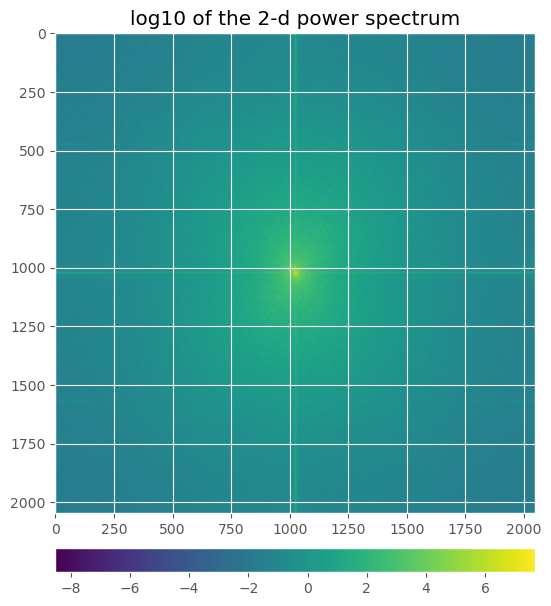

In [26]:
fig,ax=plt.subplots(1,1,figsize=(7,7))
ax.set_title('landsat a17')
im0=ax.imshow(np.log10(output.spectral_dens))
ax.set_title('log10 of the 2-d power spectrum')
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im0,orientation='horizontal',cax=cax)

In [27]:
avg_binwidth=5  #make the kradial bins 5 pixels wide
output.annular_avg(avg_binwidth)

	- INTEGRATING... 
		row: 0 completed
		row: 100 completed
		row: 200 completed
		row: 300 completed
		row: 400 completed
		row: 500 completed
		row: 600 completed
		row: 700 completed
		row: 800 completed
		row: 900 completed
		row: 1000 completed
		row: 1100 completed
		row: 1200 completed
		row: 1300 completed
		row: 1400 completed
		row: 1500 completed
		row: 1600 completed
		row: 1700 completed
		row: 1800 completed
		row: 1900 completed
		row: 2000 completed


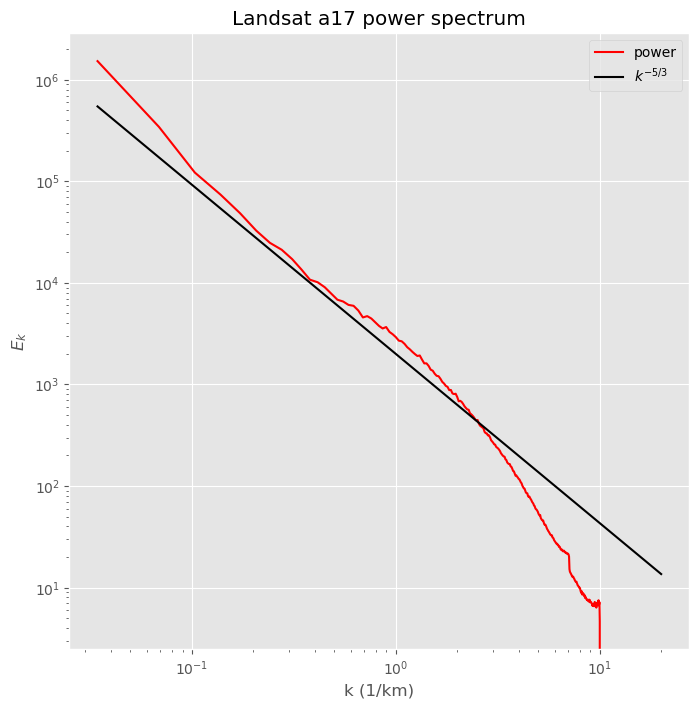

In [28]:
output.graph_spectrum(kol_offset=2000.,title='Landsat {} power spectrum'.format(output.filename))

## Problem -- lowpass filtering of a 2-d image

For the image above, 
we know that the 25 meter pixels correspond to k=1/0.025 = 40 $km^{-1}$.  That means that the Nyquist
wavenumber is k=20 $km^{-1}$.  Using that information, design a filter that removes all wavenumbers
higher than 1 $km^{-1}$.   

1) Use that filter to zero those values in the fft, then inverse transform and
plot the low-pass filtered image.

2) Take the 1-d fft of the image and repeat the plot of the power spectrum to show that there is no power in wavenumbers higher than 1 $km^{-1}$.

(Hint -- I used the fftshift function to put the low wavenumber cells in the center of the fft, which made it simpler to zero the outer cells.  I then used ifftshift to reverse shift before inverse transforming to get the filtered
image.)



## An aside about ffts: Using the fft to compute correlation

Below I use aircraft measurments of $\theta$ and wvel taken at 25 Hz.  I compute the 
autocorrelation using numpy.correlate and numpy.fft and show they are identical, as we'd expect

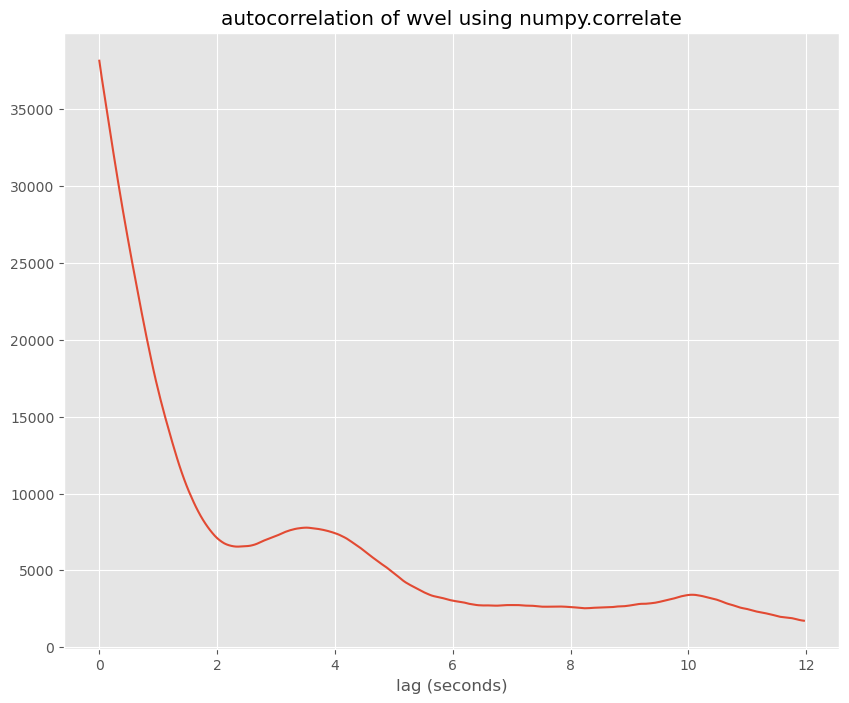

In [29]:
#http://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation
import numpy as np
%matplotlib inline
data = np.load('aircraft.npz')
wvel=data['wvel'] - data['wvel'].mean()
theta=data['theta'] - data['theta'].mean()
autocorr = np.correlate(wvel,wvel,mode='full')
auto_data = autocorr[wvel.size:]
ticks=np.arange(0,wvel.size)
ticks=ticks/25.
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.set(xlabel='lag (seconds)',title='autocorrelation of wvel using numpy.correlate')
out=ax.plot(ticks[:300],auto_data[:300])

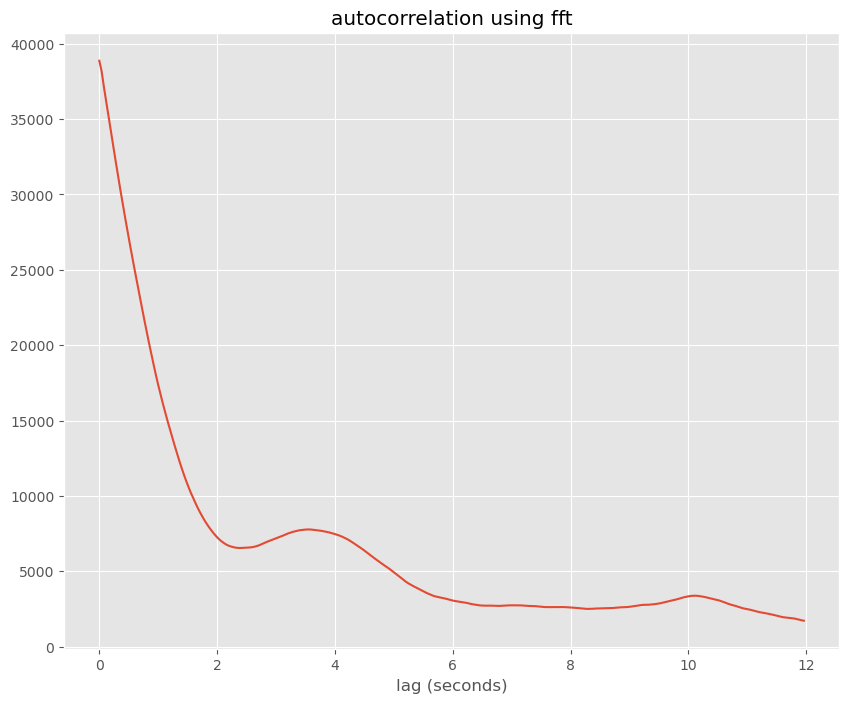

In [30]:
import numpy.fft as fft
the_fft = fft.fft(wvel)
auto_fft = the_fft*np.conj(the_fft)
auto_fft = np.real(fft.ifft(auto_fft))

fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(ticks[:300],auto_fft[:300])
out=ax.set(xlabel='lag (seconds)',title='autocorrelation using fft')

## An aside about ffts: Using ffts to find a wave envelope

Say you have a wave in your data, but it is not across all of your domain, e.g:

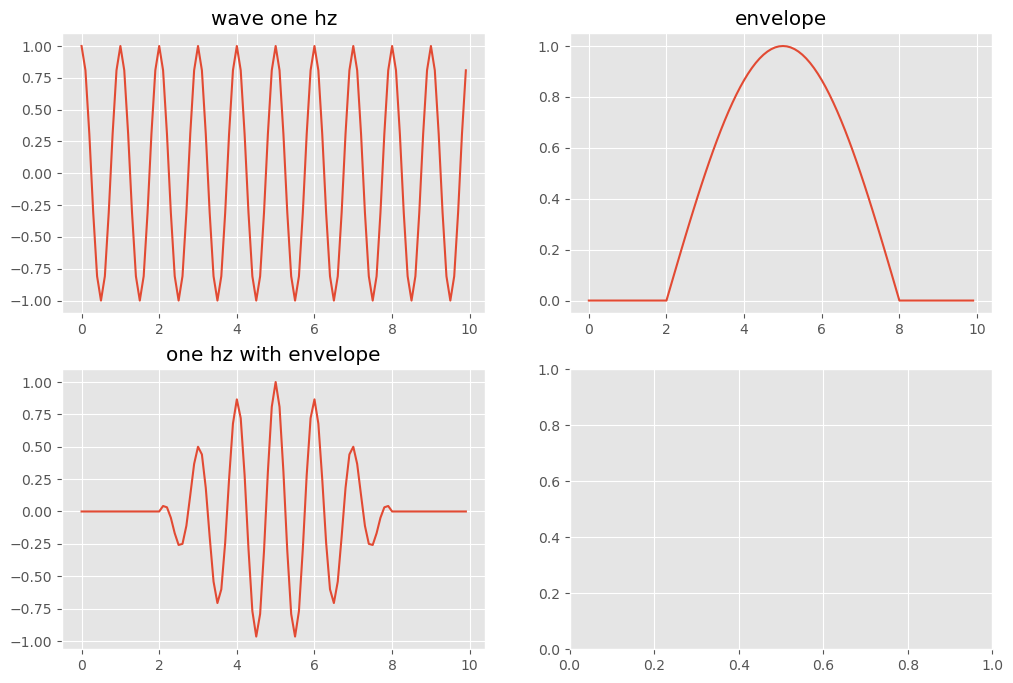

In [31]:
# Create a cosine wave modulated by a larger wavelength envelope wave

# create a cosine wave that oscilates x times in 10 seconds
# sampled at 10 Hz, so there are 10*10 = 100 measurements in 10 seconds
#
%matplotlib inline

fig,axs = plt.subplots(2,2,figsize=(12,8))

deltaT=0.1
ticks = np.arange(0,10,deltaT)

onehz=np.cos(2.0*np.pi*ticks)
axs[0,0].plot(ticks,onehz)
axs[0,0].set_title('wave one hz')

# Define an evelope function that is zero between 0 and 2 second,
# modulated by a sine wave between 2 and 8 and zero afterwards

envelope = np.empty_like(onehz)
envelope[0:20] = 0.0
envelope[20:80] = np.sin((1.0/6.0)*np.pi*ticks[0:60])
envelope[80:100] = 0.0

axs[0,1].plot(ticks,envelope)
axs[0,1].set_title('envelope')

envelopewave = onehz * envelope

axs[1,0].plot(ticks,envelopewave)
axs[1,0].set_title('one hz with envelope')
plt.show()

We can do a standard FFT on this to see the power spectrum and then recover the original wave using the inverse FFT. However, we can also use FFTs in other ways to do wavelet analysis, e.g. to find the envelope function, using a method known as the Hilbert transform (see [Zimen et al. 2003](https://nextcloud.eoas.ubc.ca/s/E2ebfKNp2mF2kY5)). This method uses the following steps:
1. Perform the fourier transform of the function.
2. Apply the inverse fourier transform to only the positive wavenumber half of the Fourier spectrum.
3. Calculate the magnitude of the result from step 2 (which will have both real and imaginary parts) and multiply by 2.0 to get the correct magnitude of the envelope function.

/Users/nduboc/opt/miniconda3/envs/numeric_2024/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nduboc/opt/miniconda3/envs/numeric_2024/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


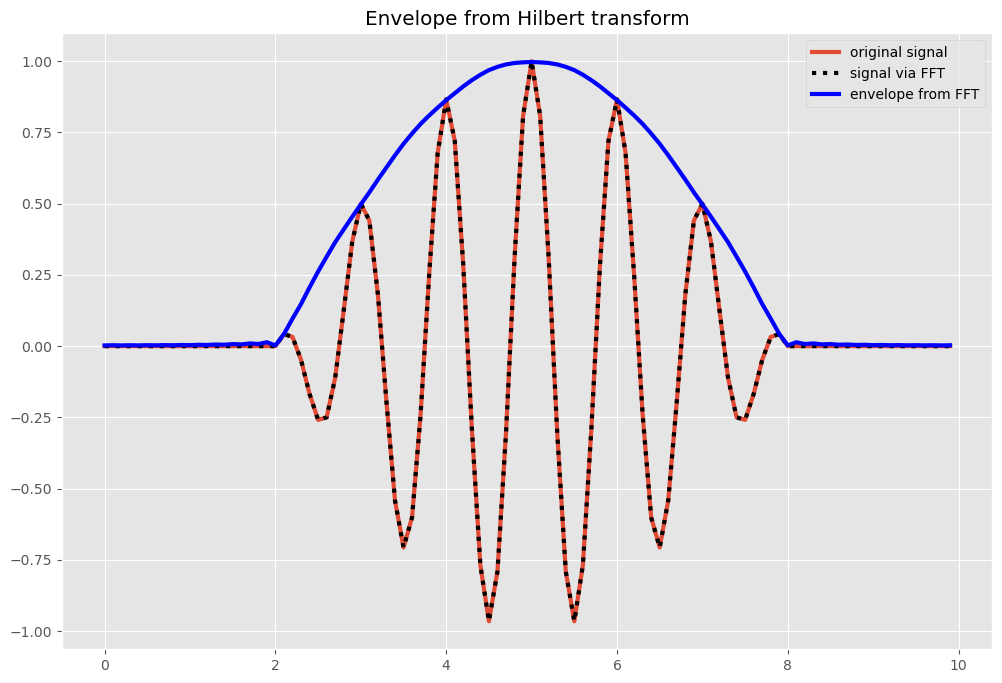

In [32]:
# Calculate the envelope function
# Step 1. FFT
thefft=np.fft.fft(envelopewave)

# Find the corresponding frequencies for each index of thefft
# note, these may not be the exact frequencies, as that will depend on the sampling resolution
# of your input data, but for this purpose we just want to know which ones are positive and
# which are negative so don't need to get the constant correct
freqs = np.fft.fftfreq(len(envelopewave))

# Step 2. Hilbert transform: set all negative frequencies to 0:
filt_fft = thefft.copy() # make a copy of the array that we will change the negative frequencies in
filt_fft[freqs<0] = 0 # set all values for negative frequenices to 0

# Inverse FFT on full field:
recover_sig = np.fft.ifft(thefft)
# inverse FFT on only the positive wavenumbers
positive_k_ifft = np.fft.ifft(filt_fft)

# Step 3. Calculate magnitude and multiply by 2:
envelope_sig = 2.0 *np.abs(positive_k_ifft)

# Plot the result
fig,axs = plt.subplots(1,1,figsize=(12,8))

deltaT=0.1
ticks = np.arange(0,10,deltaT)

axs.plot(ticks,envelopewave,linewidth=3,label='original signal')

axs.plot(ticks,recover_sig,linestyle=':',color='k',linewidth=3,label ='signal via FFT')


axs.plot(ticks,envelope_sig,linewidth=3,color='b',label='envelope from FFT')
axs.set_title('Envelope from Hilbert transform')
axs.legend(loc='best')
plt.show()
